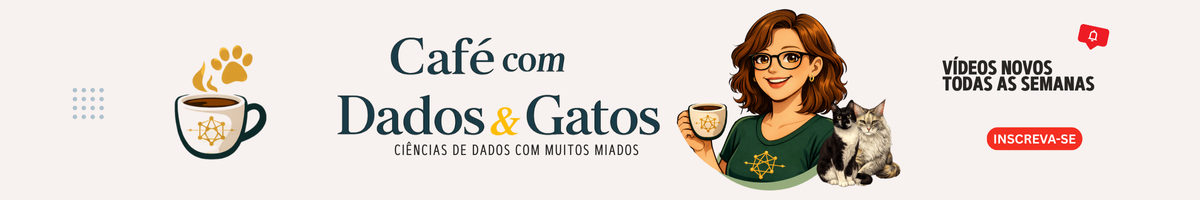

# **Matriz de Confusão (com “Alarme Falso” e “Inimigo Invisível”)**

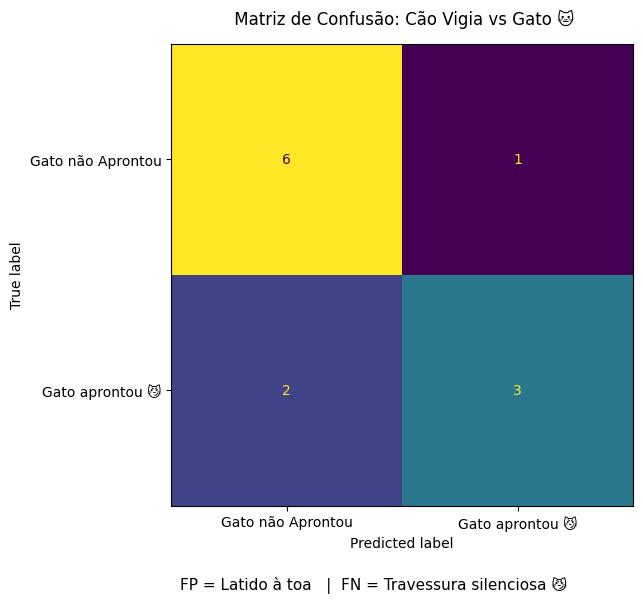

📊 Placar do Cão Vigia:
✅ VN (gato não aprontou e cão quieto): 6
✅ VP (gato aprontou e cão latiu): 3
❌ FP (latido à toa / alarme falso): 1
❌ FN (travessura silenciosa): 2

🎯 Acurácia: 0.750 (75.0%)


In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from font")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# 🐶🐱 Cenário: um cachorro vigia um gato e late quando acha que o gato vai aprontar
# Positivo (1)  = Gato aprontou
# Negativo (0)  = Gato de boa

# Verdade (o que realmente aconteceu)
# 12 situações: 5 vezes o gato aprontou (1) e 7 vezes ficou de boa (0)
y_true = np.array([1,1,1,1,1, 0,0,0,0,0,0,0])

# Previsão do cão (o que ele "avisou")
# Aqui tem FP (latido à toa) e FN (travessura silenciosa)
y_pred = np.array([1,1,0,1,0, 0,0,0,1,0,0,0])

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
vn, fp, fn, vp = cm.ravel()

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Gato não Aprontou", "Gato aprontou 😼"]
)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=None, colorbar=False, values_format='d')

ax.set_title(" Matriz de Confusão: Cão Vigia vs Gato 🐱", pad=14)
ax.text(
    0.02, -0.18,
    "FP = Latido à toa   |  FN = Travessura silenciosa 😼",
    transform=ax.transAxes,
    fontsize=11
)

plt.show()

acc = accuracy_score(y_true, y_pred)

print("📊 Placar do Cão Vigia:")
print(f"✅ VN (gato não aprontou e cão quieto): {vn}")
print(f"✅ VP (gato aprontou e cão latiu): {vp}")
print(f"❌ FP (latido à toa / alarme falso): {fp}")
print(f"❌ FN (travessura silenciosa): {fn}")
print(f"\n🎯 Acurácia: {acc:.3f} ({acc*100:.1f}%)")




# **Coeficiente Negativo na Regressão (e multicolinearidade invertendo sinal)**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def gerar_exemplo_com_inversao(max_tries=2000, n=300):
    for seed in range(max_tries):
        np.random.seed(seed)

        x1 = np.random.normal(size=n)
        x2 = x1 * 0.98 + np.random.normal(scale=0.10, size=n)

        y = 2.0*x1 + 2.0*x2 + np.random.normal(scale=1.2, size=n)

        X = pd.DataFrame({"x1": x1, "x2": x2})
        model = LinearRegression().fit(X, y)

        b1, b2 = model.coef_
        if (b1 > 0 and b2 < 0) or (b1 < 0 and b2 > 0):
            return seed, X, model

    return None, None, None

seed, X, model = gerar_exemplo_com_inversao()

if seed is None:
    print("Não encontrei inversão nesse limite. Aumente max_tries.")
else:
    corr = float(X.corr().iloc[0, 1])
    b1, b2 = model.coef_

    base = pd.DataFrame({"x1":[0.0], "x2":[0.0]})
    up_x1 = pd.DataFrame({"x1":[1.0], "x2":[0.0]})
    up_x2 = pd.DataFrame({"x1":[0.0], "x2":[1.0]})

    pred_base = float(model.predict(base)[0])
    pred_x1   = float(model.predict(up_x1)[0])
    pred_x2   = float(model.predict(up_x2)[0])

    print(f"Seed encontrada: {seed}")
    print(f"Correlação x1~x2: {corr:.3f}")
    print("Coeficientes:")
    print(pd.Series(model.coef_, index=X.columns).round(3))
    print(f"\nPredição base: {pred_base:.3f}")
    print(f"Predição aumentando x1 (mantendo x2): {pred_x1:.3f}")
    print(f"Predição aumentando x2 (mantendo x1): {pred_x2:.3f}")


Seed encontrada: 167
Correlação x1~x2: 0.996
Coeficientes:
x1   -0.242
x2    4.249
dtype: float64

Predição base: 0.029
Predição aumentando x1 (mantendo x2): -0.213
Predição aumentando x2 (mantendo x1): 4.279


# **Interpretar Probabilidades + Threshold é decisão de negócio**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Dados fictícios de 8 gatos
# Cada linha é um gato, cada coluna é um "comportamento"
X = np.array([
    [0.9, 0.2],  # gato muito suspeito
    [0.8, 0.3],
    [0.7, 0.4],
    [0.6, 0.5],
    [0.4, 0.6],
    [0.3, 0.7],
    [0.2, 0.8],
    [0.1, 0.9],  # gato tranquilo
])

# Target fictício: 1 = apronta, 0 = não apronta
y = np.array([1, 1, 1, 1, 0, 0, 0, 0])

# Treina o modelo
clf = LogisticRegression().fit(X, y)

# Probabilidade de "aprontar"
proba = clf.predict_proba(X)[:, 1]

# Organiza os gatos do mais suspeito para o menos suspeito
df = pd.DataFrame({
    "Gato": [f"Gato {i+1}" for i in range(len(X))],
    "Prob_aprontar": proba.round(3),
    "Aprontou_de_verdade": y
}).sort_values("Prob_aprontar", ascending=False)

print("Gatos ordenados por risco:")
display(df)

# Testa diferentes thresholds
for thr in [0.5, 0.7, 0.9]:
    y_pred = (proba >= thr).astype(int)
    positivos = y_pred.sum()
    print(f"Threshold {thr}: gatos marcados como 'alto risco' = {positivos} de {len(y_pred)}")


Gatos ordenados por risco:


,Gato,Prob_aprontar,Aprontou_de_verdade
0,Gato 1,0.633,1
1,Gato 2,0.599,1
2,Gato 3,0.564,1
3,Gato 4,0.528,1
4,Gato 5,0.472,0
5,Gato 6,0.436,0
6,Gato 7,0.401,0
7,Gato 8,0.367,0


Threshold 0.5: gatos marcados como 'alto risco' = 4 de 8
Threshold 0.7: gatos marcados como 'alto risco' = 0 de 8
Threshold 0.9: gatos marcados como 'alto risco' = 0 de 8


# **Modelo Instável = Alta Variância (seed muda o resultado)**

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_classification(n_samples=350, n_features=15, n_informative=4,
                           n_redundant=3, flip_y=0.05, random_state=42)

scores = []
for seed in range(1, 16):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.35, random_state=seed, stratify=y)
    model = DecisionTreeClassifier(max_depth=None, random_state=seed)  # tende a variar
    model.fit(Xtr, ytr)
    acc = accuracy_score(yte, model.predict(Xte))
    scores.append(acc)

print("Acurácias mudando com a seed:")
print([round(s, 3) for s in scores])
print("\nMédia:", round(np.mean(scores), 3), "| Desvio padrão (instabilidade/variância):", round(np.std(scores), 3))


Acurácias mudando com a seed:
[0.707, 0.683, 0.707, 0.772, 0.756, 0.74, 0.772, 0.74, 0.715, 0.78, 0.74, 0.772, 0.699, 0.667, 0.74]

Média: 0.733 | Desvio padrão (instabilidade/variância): 0.034


# **Data Leakage - O Mistério do Gato e o Vaso**

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.random.seed(0)
n = 800

# "Chuva" (target) - 0/1
y = (np.random.rand(n) < 0.25).astype(int)

# Feature legítima (ruído + um pouco de sinal)
x_legit = np.random.normal(size=n) + 0.3*y

# Feature com vazamento: "guarda-chuva aberto" (quase revela o futuro)
x_leak = y + np.random.normal(scale=0.05, size=n)

# Sem leakage
X1 = np.c_[x_legit]
X1tr, X1te, ytr, yte = train_test_split(X1, y, test_size=0.35, random_state=1, stratify=y)
m1 = LogisticRegression(max_iter=1000).fit(X1tr, ytr)
acc1_tr = accuracy_score(ytr, m1.predict(X1tr))
acc1_te = accuracy_score(yte, m1.predict(X1te))

# Com leakage
X2 = np.c_[x_legit, x_leak]
X2tr, X2te, ytr2, yte2 = train_test_split(X2, y, test_size=0.35, random_state=1, stratify=y)
m2 = LogisticRegression(max_iter=1000).fit(X2tr, ytr2)
acc2_tr = accuracy_score(ytr2, m2.predict(X2tr))
acc2_te = accuracy_score(yte2, m2.predict(X2te))

print("SEM leakage -> treino:", round(acc1_tr,3), "teste:", round(acc1_te,3))
print("COM leakage -> treino:", round(acc2_tr,3), "teste:", round(acc2_te,3))
print("\nLeakage é como prever chuva vendo guarda-chuva aberto: parece mágico, mas é trapaça.")


SEM leakage -> treino: 0.74 teste: 0.743
COM leakage -> treino: 1.0 teste: 1.0

Leakage é como prever chuva vendo guarda-chuva aberto: parece mágico, mas é trapaça.


# **Acurácia vs Matriz de Confusão: “cadê os gatos de raça?”**

Acurácia: 0.95 (alta, mas pode ser inútil em desbalanceado)


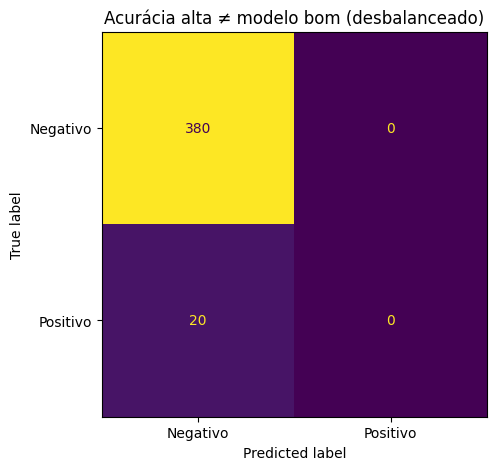

TN=380  FP=0  FN=20  TP=0  -> Repare: TP=0 (não pega nenhum positivo!)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Dataset desbalanceado: 95% negativos, 5% positivos
n = 400
y_true = np.array([0]*380 + [1]*20)

# Modelo "burro": prevê tudo negativo
y_pred = np.zeros_like(y_true)

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

print("Acurácia:", round(acc, 3), "(alta, mas pode ser inútil em desbalanceado)")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Positivo"])

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap=None, colorbar=False)
ax.set_title("Acurácia alta ≠ modelo bom (desbalanceado)")
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}  -> Repare: TP=0 (não pega nenhum positivo!)")
